In [267]:
import os

# Replace this with your actual path if different
train_path = "/Users/cherry/Documents/DL_PROJECT/Skin_Cancer_Classification_DL_Project (1)/train"

print("Exists:", os.path.exists(train_path))

Exists: True


In [269]:
import numpy as np

train_path = "/Users/cherry/Documents/DL_PROJECT/Skin_Cancer_Classification_DL_Project (1)/train"
val_path = "/Users/cherry/Documents/DL_PROJECT/Skin_Cancer_Classification_DL_Project (1)/val"

def get_images_and_labels(folder_path):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            label = int(filename.split("_")[0]) - 1  # convert to 0-indexed
            img_path = os.path.join(folder_path, filename)
            img = load_img(img_path, color_mode='grayscale', target_size=(224, 224))
            img_array = img_to_array(img)
            
            #grayscale to RGB 
            
            img_rgb = np.repeat(img_array, 3, axis=2)
            images.append(img_rgb)
            labels.append(label)
    return np.array(images), np.array(labels)

train_images, train_labels = get_images_and_labels(train_path)
val_images, val_labels = get_images_and_labels(val_path)

print("Train shape:", train_images.shape, train_labels.shape)
print("Val shape:", val_images.shape, val_labels.shape)

Train shape: (3000, 224, 224, 3) (3000,)
Val shape: (1000, 224, 224, 3) (1000,)


In [271]:
train_images = train_images / 255.0
val_images = val_images / 255.0

train_images, val_images


(array([[[[0.7490196 , 0.7490196 , 0.7490196 ],
          [0.68235296, 0.68235296, 0.68235296],
          [0.7607843 , 0.7607843 , 0.7607843 ],
          ...,
          [0.6784314 , 0.6784314 , 0.6784314 ],
          [0.654902  , 0.654902  , 0.654902  ],
          [0.6       , 0.6       , 0.6       ]],
 
         [[0.39607844, 0.39607844, 0.39607844],
          [0.75686276, 0.75686276, 0.75686276],
          [0.7137255 , 0.7137255 , 0.7137255 ],
          ...,
          [0.7019608 , 0.7019608 , 0.7019608 ],
          [0.68235296, 0.68235296, 0.68235296],
          [0.6431373 , 0.6431373 , 0.6431373 ]],
 
         [[0.60784316, 0.60784316, 0.60784316],
          [0.7019608 , 0.7019608 , 0.7019608 ],
          [0.95686275, 0.95686275, 0.95686275],
          ...,
          [0.6862745 , 0.6862745 , 0.6862745 ],
          [0.67058825, 0.67058825, 0.67058825],
          [0.63529414, 0.63529414, 0.63529414]],
 
         ...,
 
         [[0.80784315, 0.80784315, 0.80784315],
          [0.80784

In [273]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])


In [275]:
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False  # Freeze for transfer learning

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')  # 7 skin cancer classes
])

train_images = np.squeeze(train_images)
val_images = np.squeeze(val_images)

print("Train shape after squeeze:", train_images.shape)
print("Val shape after squeeze:", val_images.shape)

if train_images.ndim > 4:
    train_images = train_images.reshape((-1, 224, 224, 3))
    val_images = val_images.reshape((-1, 224, 224, 3))


Train shape after squeeze: (3000, 224, 224, 3)
Val shape after squeeze: (1000, 224, 224, 3)


In [277]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

# Shuffle and batch
BATCH_SIZE = 32

train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [279]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input

# Number of output classes
NUM_CLASSES = 7

# MobileNetV2 expects input shape to be (224, 224, 3)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze base model
base_model.trainable = False

# Add custom top layers
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_a = Model(inputs, outputs)

# Compile
model_a.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

model_a.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_19     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 213ms/step - accuracy: 0.7871 - loss: 0.5632 - val_accuracy: 0.7080 - val_loss: 1.0168
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - accuracy: 0.7993 - loss: 0.5718 - val_accuracy: 0.7110 - val_loss: 0.9762
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 222ms/step - accuracy: 0.8032 - loss: 0.5563 - val_accuracy: 0.7080 - val_loss: 1.0578
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 232ms/step - accuracy: 0.8049 - loss: 0.5371 - val_accuracy: 0.7120 - val_loss: 0.9914
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 244ms/step - accuracy: 0.8019 - loss: 0.5401 - val_accuracy: 0.7180 - val_loss: 0.9864
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 239ms/step - accuracy: 0.8046 - loss: 0.5381 - val_accuracy: 0.7190 - val_loss: 1.0103
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 249ms/step - accuracy: 0.7874 - loss: 0.5714 - val_accuracy: 0.7140 - val_loss: 0.9773
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 276ms/step - accuracy: 0.7920 - loss: 0.5657 - val_accu

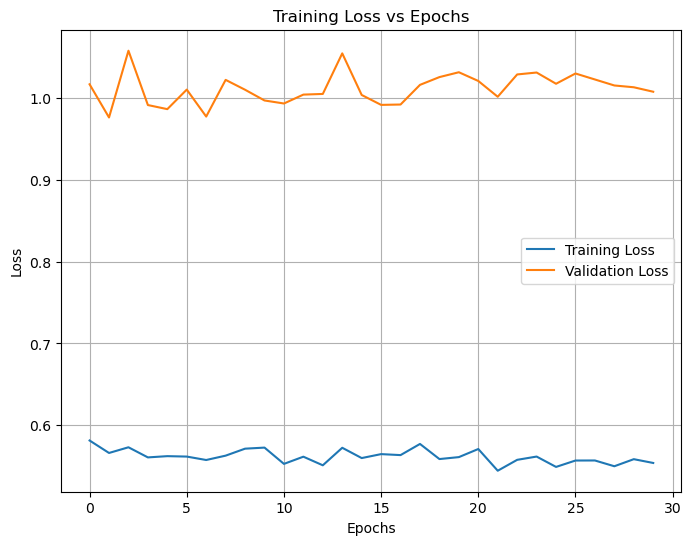

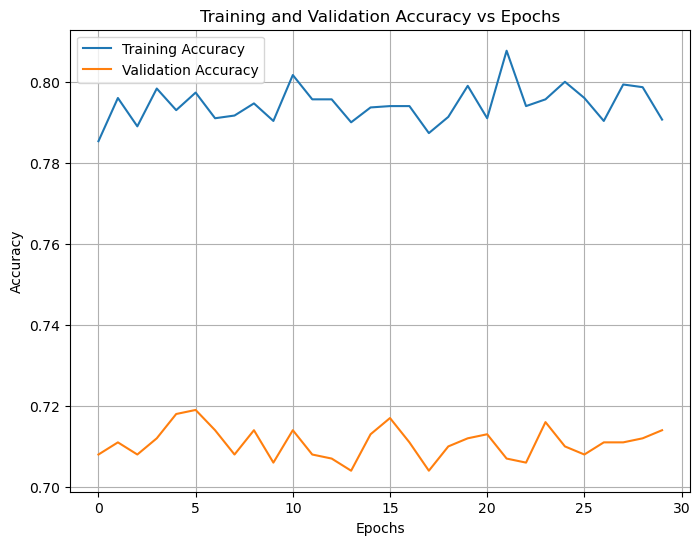

Final Training Accuracy: 0.7907
Final Validation Accuracy: 0.7140


In [307]:
history_a = model_a.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30
)

import matplotlib.pyplot as plt
import tensorflow as tf

# 1. Plotting Training Loss vs Epochs
plt.figure(figsize=(8, 6))
plt.plot(history_a.history['loss'], label='Training Loss')
plt.plot(history_a.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 2. Plotting Accuracy vs Epochs (Training and Validation)
plt.figure(figsize=(8, 6))
plt.plot(history_a.history['accuracy'], label='Training Accuracy')
plt.plot(history_a.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 3. Final Accuracy Values
train_accuracy = history_a.history['accuracy'][-1]
val_accuracy = history_a.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

In [309]:
from tensorflow.keras.layers import BatchNormalization


base_model_b = MobileNetV2(input_shape=(224, 224, 3),
                           include_top=False,
                           weights='imagenet')

for layer in base_model_b.layers[-30:]:
    layer.trainable = True

inputs_b = Input(shape=(224, 224, 3))
x = base_model_b(inputs_b, training=True)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  
x = Dropout(0.4)(x)         
x = Dense(128, activation='relu')(x)  # Added Dense layer before final output
x = Dropout(0.3)(x)
outputs_b = Dense(NUM_CLASSES, activation='softmax')(x)

model_b = Model(inputs_b, outputs_b)

# Compile with a different optimizer
model_b.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

model_b.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_37 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_20     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,975 (9.26 MB)

 Trainable params: 2,391,303 (9.12 MB)

 Non-trainable params: 36,672 (143.25 KB)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.2460 - loss: 2.6004 - val_accuracy: 0.1200 - val_loss: 2.0385
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.6318 - loss: 1.1936 - val_accuracy: 0.6700 - val_loss: 1.6898
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.7172 - loss: 0.8335 - val_accuracy: 0.6690 - val_loss: 2.0404
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.7583 - loss: 0.7191 - val_accuracy: 0.6700 - val_loss: 1.8814
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.8094 - loss: 0.5306 - val_accuracy: 0.6690 - val_loss: 1.8927
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.8554 - loss: 0.4464 - val_accuracy: 0.6650 - val_loss: 2.0411
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.8904 - loss: 0.3140 - val_accuracy: 0.6690 - val_loss: 2.3258
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.9148 - loss: 0.2412 - val_accuracy: 0.6670 - v

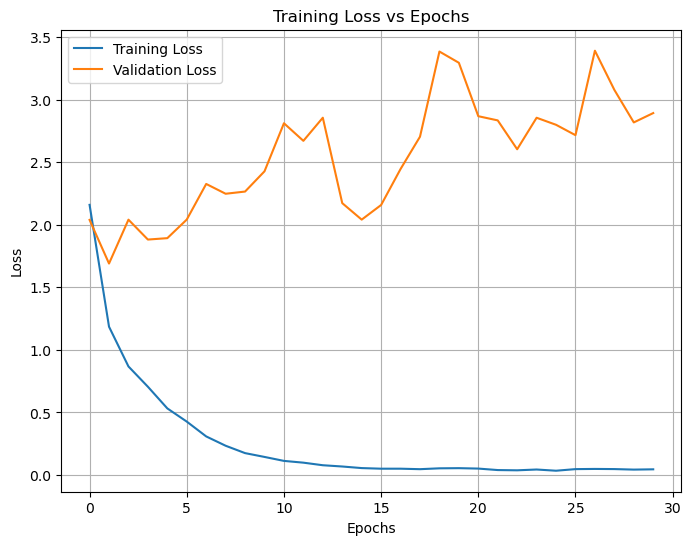

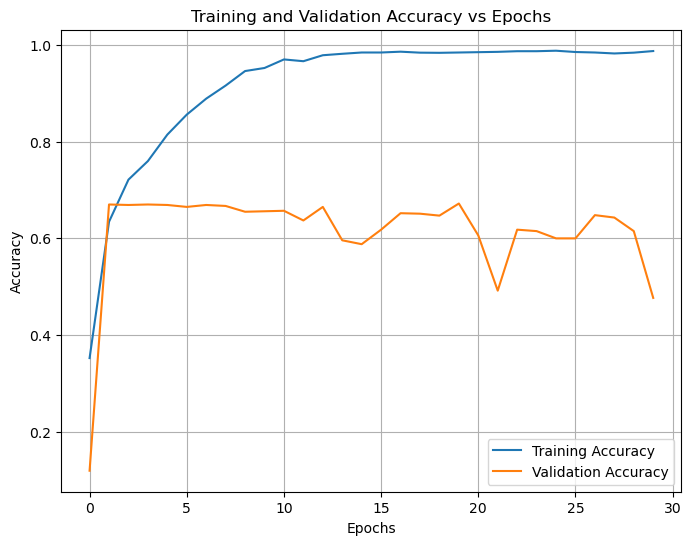

Final Training Accuracy: 0.9870
Final Validation Accuracy: 0.4770


In [311]:
history_b = model_b.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30
)

import matplotlib.pyplot as plt
import tensorflow as tf

# Plotting Training Loss vs Epochs
plt.figure(figsize=(8, 6))
plt.plot(history_b.history['loss'], label='Training Loss')
plt.plot(history_b.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Accuracy vs Epochs 
plt.figure(figsize=(8, 6))
plt.plot(history_b.history['accuracy'], label='Training Accuracy')
plt.plot(history_b.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Final Accuracy Values
train_accuracy = history_b.history['accuracy'][-1]
val_accuracy = history_b.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

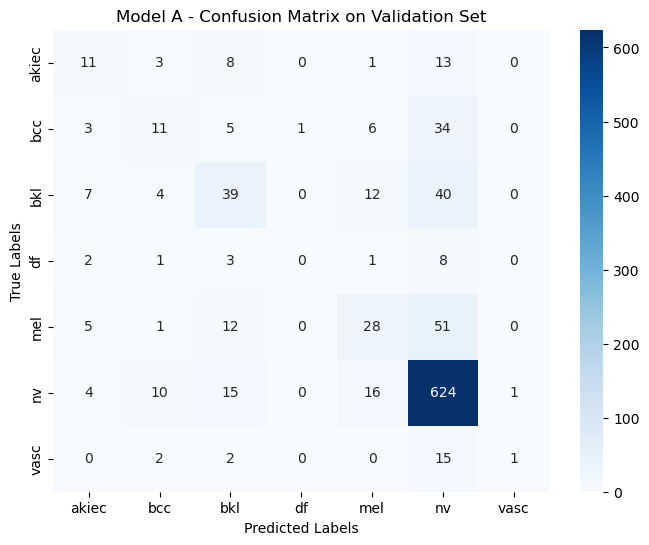


Classification Report for Model A:

              precision    recall  f1-score   support

       akiec       0.34      0.31      0.32        36
         bcc       0.34      0.18      0.24        60
         bkl       0.46      0.38      0.42       102
          df       0.00      0.00      0.00        15
         mel       0.44      0.29      0.35        97
          nv       0.79      0.93      0.86       670
        vasc       0.50      0.05      0.09        20

    accuracy                           0.71      1000
   macro avg       0.41      0.31      0.33      1000
weighted avg       0.67      0.71      0.68      1000



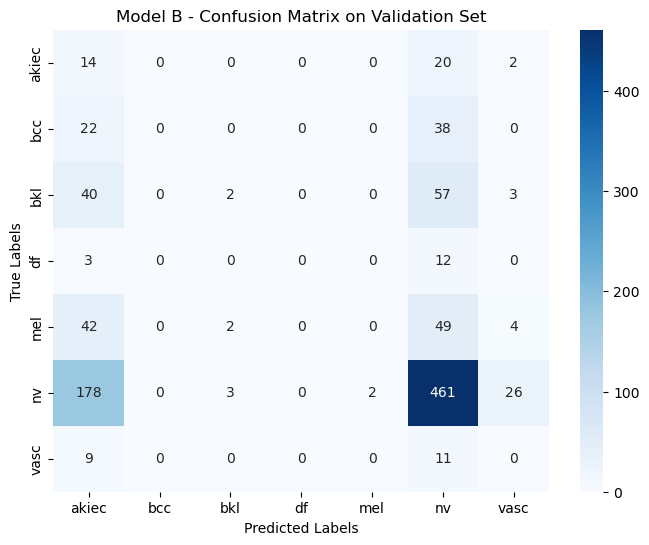


Classification Report for Model B:

              precision    recall  f1-score   support

       akiec       0.05      0.39      0.08        36
         bcc       0.00      0.00      0.00        60
         bkl       0.29      0.02      0.04       102
          df       0.00      0.00      0.00        15
         mel       0.00      0.00      0.00        97
          nv       0.71      0.69      0.70       670
        vasc       0.00      0.00      0.00        20

    accuracy                           0.48      1000
   macro avg       0.15      0.16      0.12      1000
weighted avg       0.51      0.48      0.48      1000



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [315]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

# Function to generate and display confusion matrix
def plot_confusion_matrix(model, val_images, val_labels, model_name="Model"):
    # Predict labels
    predictions = model.predict(val_images, verbose=0)
    y_pred = np.argmax(predictions, axis=1)

    # Generate confusion matrix
    cm = confusion_matrix(val_labels, y_pred)
    class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

    # Plotting
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"{model_name} - Confusion Matrix on Validation Set")
    plt.show()

    # Optional: Print classification report
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(val_labels, y_pred, target_names=class_names))

# Usage for both models
plot_confusion_matrix(model_a, val_images, val_labels, model_name="Model A")
plot_confusion_matrix(model_b, val_images, val_labels, model_name="Model B")

In [ ]:
# Saving model a weights
model_a.save_weights("model_a.weights.h5")

# Saving model b weights
model_b.save_weights("model_b.weights.h5")

In [343]:
model_a.save("model_a.keras")
model_b.save("model_b.keras")

In [ ]:
#Testing

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all logs, 3 = only fatal

class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

def preprocess_test_image(img_path):
    img = image.load_img(img_path, color_mode='grayscale', target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_rgb = np.repeat(img_array, 3, axis=2)
    img_rgb = img_rgb / 255.0
    return np.expand_dims(img_rgb, axis=0)

def evaluate_model_on_test(model, test_folder_path):
    y_true, y_pred = [], []

    for fname in os.listdir(test_folder_path):
        if fname.lower().endswith(('.jpg', '.png')):
            label = int(fname.split("_")[0]) - 1
            img_path = os.path.join(test_folder_path, fname)
            img_tensor = preprocess_test_image(img_path)
            
            pred = model.predict(img_tensor, verbose=0)
            predicted_class = np.argmax(pred)
            y_true.append(label)
            y_pred.append(predicted_class)

    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n Model_A Test Accuracy: {accuracy:.4f}")

# For Testing
test_folder_path = "Enter your file path"
evaluate_model_on_test(model_a, test_folder_path)